## Downgrade Pandas version to be compatible with Maya Python

Downgrade Pandas version so the models saved can be compatible to use in Maya

In [ ]:
!pip install pandas==1.3.5

In [ ]:
import pandas as pd
print(pd.__version__)

1.3.5


# Skewed Genralized Normal Distribution Function and Example

Yawning involves
*   A long inspiratory phase with gradual mouth gaping, jaw widening, and respiratory muscles contracting.
*   An acme with maximal muscle stretching.
*   A rapid expiratory phase with muscle tension release.

Many blendshapes' curves have three phases as shown below:

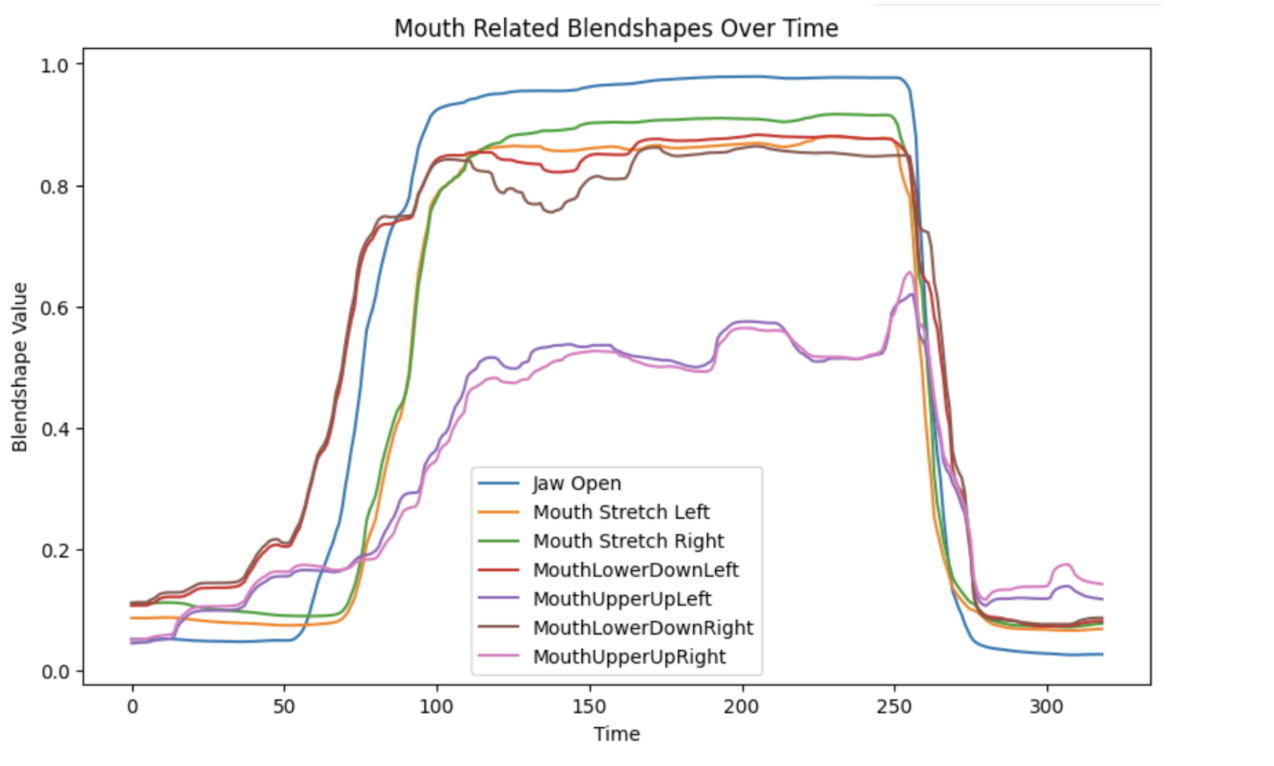

We use skewed generalized normal distribution to capture typical blendshapes that have three phases (shark fin curves).

Skewed Generalized Normal Distribution:

*   **Skewness parameter**: capture the difference in speed between muscles contract and muscles release
*   **Shape parameter of GND (beta)**: capture the plateau of the curve
*   **Mean**: control yawning duration
*   **Standard deviation (sigma)**: control yawning duration
*   **Max value**: control mouth openness during yawning
*   **Min value**: control blendshape min value









Skewed Generalized Normal Distribution can capture this curve pattern very well:

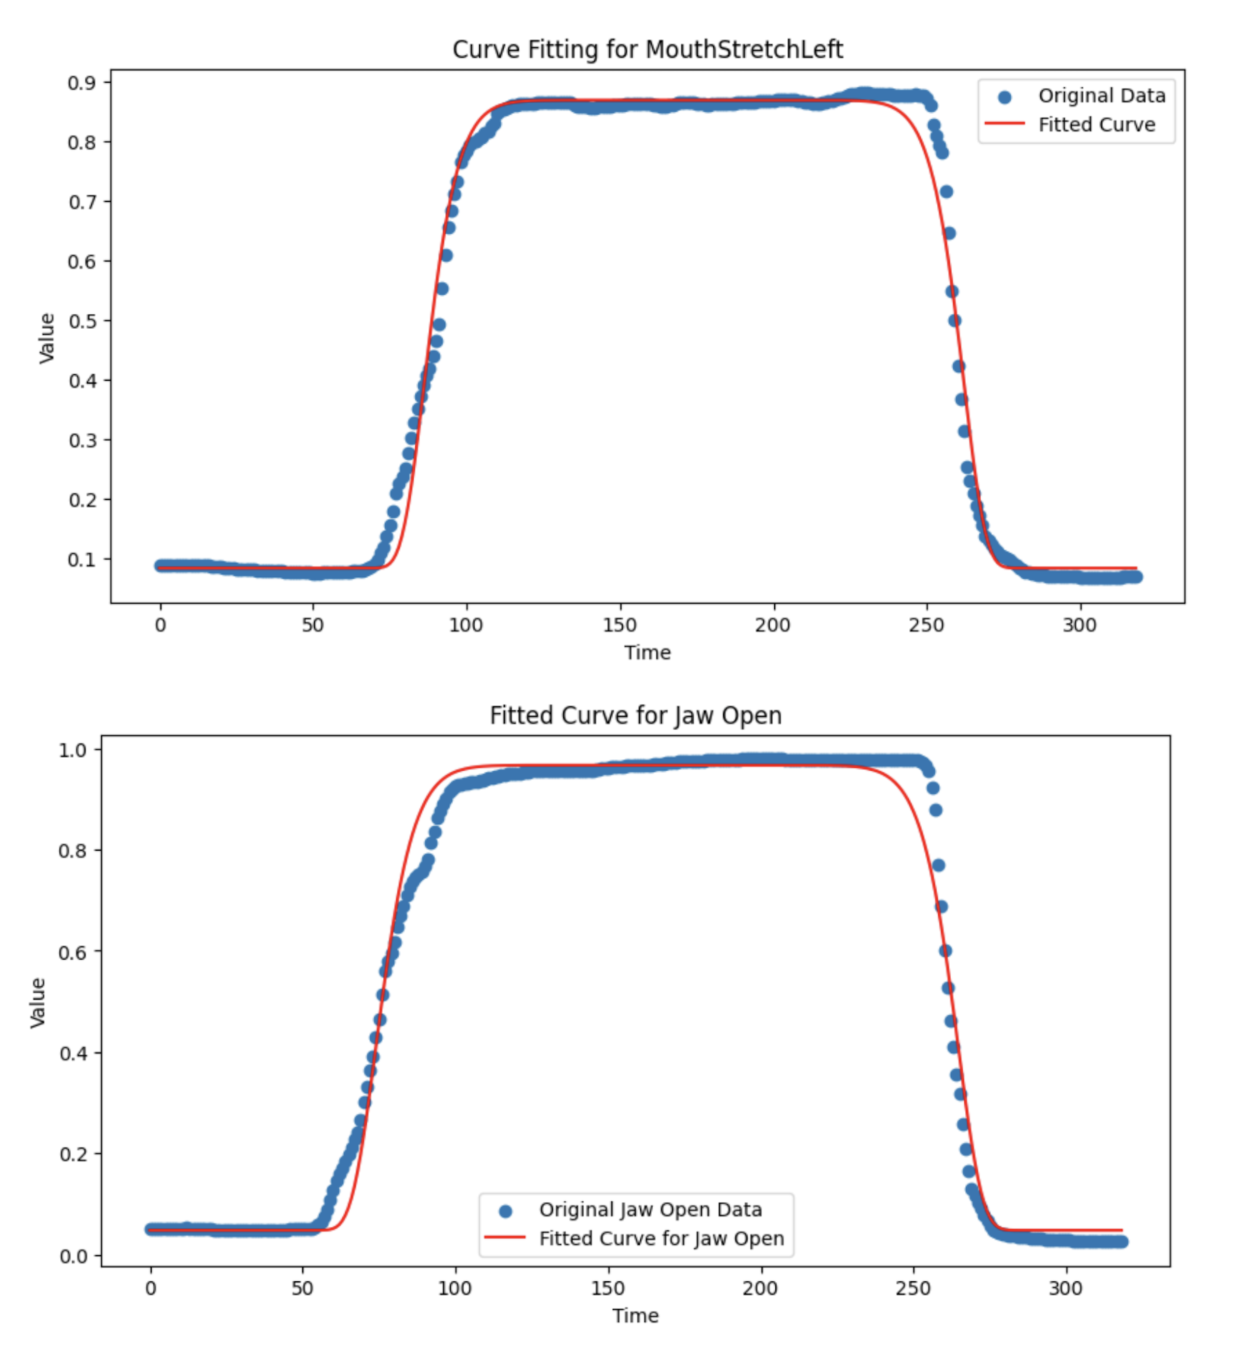

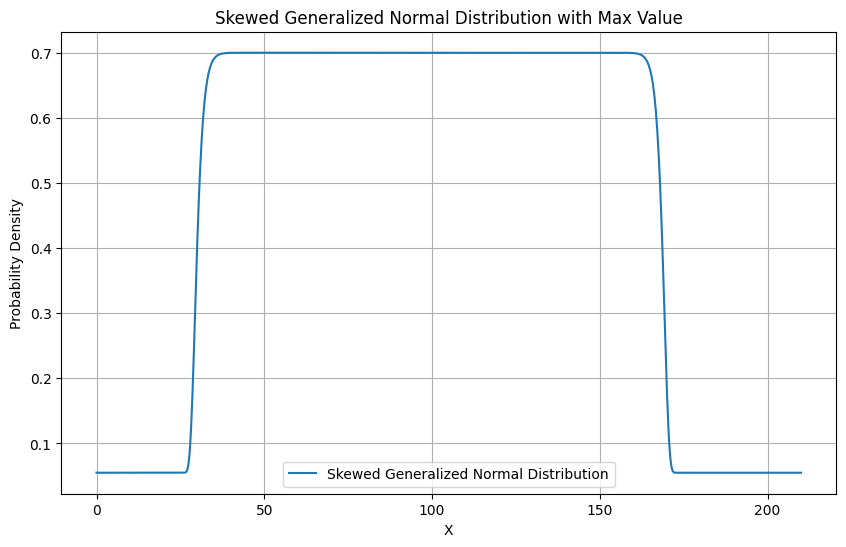

In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gamma
from scipy.optimize import minimize_scalar

# Define the PDF of the Generalized Normal Distribution
def gennorm_pdf(x, beta, mean, sigma):
    return np.exp(-np.abs((x - mean) / sigma)**beta) / (2 * sigma * gamma(1/beta) * (1/beta)**(1/beta))

# Define a skewing function using the CDF of the normal distribution
def skewing_function(x, alpha):
    return 2 * norm.cdf(alpha * x)

# Internal function to calculate the amplitude A
def _calculate_amplitude(beta, max_value, sigma, y_min, mean, alpha):
    def objective_function(A):
        y_values = A * gennorm_pdf(x_values, beta, mean, sigma) * skewing_function(x_values, alpha) + y_min
        return np.abs(max(y_values) - max_value)

    x_values = np.linspace(mean - 5*sigma, mean + 5*sigma, 1000)
    result = minimize_scalar(objective_function)
    return result.x

# Modified function to calculate the skewed GND PDF
def skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean, alpha=5):
    A = _calculate_amplitude(beta, max_value, sigma, y_min, mean, alpha)
    return A * gennorm_pdf(x, beta, mean, sigma) * skewing_function(x, alpha) + y_min

# Example usage
beta = 50
max_value = 0.7
sigma = 70
y_min = 0.055121
mean = 99.328859
alpha = 20

# Generate the skewed GND PDF with internally calculated amplitude
x = np.linspace(0, 210, 1000)
y = skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean, alpha)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Skewed Generalized Normal Distribution')
plt.title('Skewed Generalized Normal Distribution with Max Value')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

# Fit skewed generalized normal distribution curves to jaw/mouth/cheek blendshapes

Fit skewed generalized normal distribution curves to jaw/mouth/cheek blendshapes to find skewed generalized normal distribution curves' parameters for the yawning data we collected using Livelink.

In [ ]:
import math
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import gamma
from scipy.special import gammainc
from scipy.optimize import curve_fit
import pandas as pd

csv_files = glob.glob('*.csv')
blendshapes = ["MouthStretchLeft", "MouthStretchRight", "MouthLowerDownLeft",
               "MouthLowerDownRight", "MouthUpperUpLeft", "MouthUpperUpRight",
               "JawForward", "MouthFunnel", 'MouthShrugLower', 'MouthShrugUpper',
               "MouthClose", "MouthPucker", "MouthRollLower", "MouthRollUpper",
               "MouthPressLeft", "MouthPressRight", "CheekPuff", "CheekSquintLeft",
               "CheekSquintRight", "HeadPitch", "MouthSmileLeft", "MouthSmileRight",
               "MouthDimpleLeft", "MouthDimpleRight"]
all_blendshapes = ["JawOpen"] + blendshapes
metrics = ["beta", "y_min", "mean", "sigma", "max_value"]
static_keys = {"csv_name": [], "num_frames": [],
              "JawOpen_max_value": [], "JawOpen_y_min": [], "JawOpen_mean": [],
              "JawOpen_sigma": [], "JawOpen_beta": []}
dynamic_keys = {f"{blendshape}_{metric}": [] for blendshape in blendshapes for metric in metrics}
summary_df = {**static_keys, **dynamic_keys}

for filename in csv_files:
    df = pd.read_csv(filename)
    time_data = df.index
    summary_df["csv_name"].append(filename)
    summary_df["num_frames"].append(len(df))

    for blendshape in all_blendshapes:
      # negative correlation with JawOpen
      if blendshape == "MouthShrugLower" or blendshape == "MouthShrugUpper" or \
      blendshape == "MouthRollLower" or blendshape == "MouthRollUpper" or \
      blendshape == "MouthPressLeft" or blendshape == "MouthPressRight" or \
      blendshape == "CheekPuff" or blendshape == "CheekSquintLeft" or \
      blendshape == "CheekSquintRight":
        y_data = 1-df[blendshape]
      else:
        y_data = df[blendshape]
      summary_df[f"{blendshape}_y_min"].append(y_data.min())
      # variant of skewed generalized normal distribution (half curve)
      if blendshape in ["MouthSmileLeft", "MouthSmileRight", "MouthDimpleLeft", "MouthDimpleRight"]:
        mean = len(time_data)
      else:
        mean = np.sum(time_data * y_data) / np.sum(y_data)
      summary_df[f"{blendshape}_mean"].append(mean)

      # adjust initial beta guessing for curve_fitting
      if filename in ["MySlate_46_iPhone.csv"] and blendshape == "MouthStretchLeft":
        initial_guess = [7]
      elif filename in ["MySlate_68_iPhone.csv"] and blendshape == "MouthStretchLeft":
        initial_guess = [3]
      elif filename in ["MySlate_68_iPhone.csv"] and blendshape == "MouthStretchRight":
        initial_guess = [11]
      elif filename in ["MySlate_46_iPhone.csv"] and blendshape == "MouthLowerDownLeft":
        initial_guess = [8]
      elif filename in ["MySlate_17_iPhone.csv", "MySlate_2_iPhone.csv"] and blendshape == "MouthUpperUpRight":
        initial_guess = [12]
      elif filename in ["MySlate_17_iPhone.csv"] and blendshape == "MouthUpperUpLeft":
        initial_guess = [12]
      elif filename in ["MySlate_45_iPhone.csv"] and blendshape == "MouthUpperUpRight":
        initial_guess = [15]
      elif filename in ["MySlate_45_iPhone.csv", "MySlate_46_iPhone.csv"] and blendshape == "MouthUpperUpLeft":
        initial_guess = [12]
      elif filename in ["MySlate_65_iPhone.csv"] and blendshape == "MouthUpperUpRight":
        initial_guess = [20]
      elif filename in ["MySlate_65_iPhone.csv", "MySlate_68_iPhone.csv"] and blendshape == "MouthUpperUpLeft":
        initial_guess = [13]
      elif filename in ["MySlate_68_iPhone.csv"] and blendshape == "JawForward":
        initial_guess = [17]
      elif filename in ["MySlate_9_iPhone.csv"] and blendshape == "JawForward":
        initial_guess = [13]
      elif filename in ["MySlate_2_iPhone.csv", "MySlate_43_iPhone.csv"] and blendshape == "MouthFunnel":
        initial_guess = [11]
      elif filename in ["MySlate_46_iPhone.csv"] and blendshape == "MouthFunnel":
        initial_guess = [13]
      elif filename in ["MySlate_68_iPhone.csv", "MySlate_9_iPhone.csv"] and blendshape == "MouthFunnel":
        initial_guess = [12]
      elif filename in ["MySlate_17_iPhone.csv", "MySlate_25_iPhone.csv", "MySlate_43_iPhone.csv", "MySlate_72_iPhone.csv", "MySlate_9_iPhone.csv"] and \
      blendshape == "MouthShrugLower":
        initial_guess = [15]
      elif filename in ["MySlate_42_iPhone.csv"] and blendshape == "MouthShrugLower":
        initial_guess = [11]
      elif filename in ["MySlate_17_iPhone.csv", "MySlate_25_iPhone.csv", "MySlate_2_iPhone.csv", "MySlate_42_iPhone.csv", "MySlate_43_iPhone.csv", "MySlate_68_iPhone.csv"] and \
      blendshape == "MouthShrugUpper":
        initial_guess = [13]
      elif filename in ["MySlate_43_iPhone.csv"] and blendshape == "MouthClose":
        initial_guess = [13]
      elif filename in ["MySlate_46_iPhone.csv"] and blendshape == "MouthClose":
        initial_guess = [11]
      elif filename in ["MySlate_42_iPhone.csv"] and blendshape == "MouthPucker":
        initial_guess = [11]
      elif filename in ["MySlate_43_iPhone.csv"] and blendshape == "MouthPucker":
        initial_guess = [16]
      elif filename in ["MySlate_68_iPhone.csv"] and blendshape == "MouthPucker":
        initial_guess = [14]
      elif filename in ["MySlate_17_iPhone.csv"] and blendshape == "MouthRollLower":
        initial_guess = [13]
      elif filename in ["MySlate_2_iPhone.csv"] and blendshape == "MouthRollLower":
        initial_guess = [11]
      elif filename in ["MySlate_43_iPhone.csv", "MySlate_9_iPhone.csv"] and blendshape == "MouthRollLower":
        initial_guess = [12]
      elif filename in ["MySlate_25_iPhone.csv"] and blendshape == "MouthRollUpper":
        initial_guess = [11]
      elif filename in ["MySlate_42_iPhone.csv", "MySlate_43_iPhone.csv"] and blendshape == "MouthPressLeft":
        initial_guess = [11]
      elif filename in ["MySlate_45_iPhone.csv"] and blendshape == "MouthPressLeft":
        initial_guess = [12]
      elif filename in ["MySlate_2_iPhone.csv"] and blendshape == "MouthPressRight":
        initial_guess = [13]
      elif filename in ["MySlate_45_iPhone.csv"] and blendshape == "MouthPressRight":
        initial_guess = [14]
      elif filename in ["MySlate_68_iPhone.csv"] and blendshape == "MouthPressRight":
        initial_guess = [11]
      elif filename in ["MySlate_25_iPhone.csv"] and blendshape == "CheekPuff":
        initial_guess = [15]
      elif filename in ["MySlate_2_iPhone.csv"] and blendshape == "CheekPuff":
        initial_guess = [12]
      elif filename in ["MySlate_45_iPhone.csv", "MySlate_68_iPhone.csv", "MySlate_9_iPhone.csv"] and blendshape == "CheekPuff":
        initial_guess = [11]
      elif filename in ["MySlate_65_iPhone.csv"] and blendshape == "CheekPuff":
        initial_guess = [13]
      elif filename in ["MySlate_25_iPhone.csv", "MySlate_46_iPhone.csv"] and blendshape == "CheekSquintLeft":
        initial_guess = [13]
      elif filename in ["MySlate_66_iPhone.csv"] and blendshape == "CheekSquintRight":
        initial_guess = [13]
      else:
        initial_guess = [10]
      y_min = y_data.min()
      max_value = y_data.max()
      summary_df[f"{blendshape}_max_value"].append(max_value)
      sigma = math.sqrt(np.sum((time_data - mean)**2) / len(time_data))
      summary_df[f"{blendshape}_sigma"].append(sigma)


      popt, pcov = curve_fit(
          lambda x, beta: skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean),
          time_data,
          y_data,
          p0=initial_guess,
          maxfev=10000
      )
      summary_df[f"{blendshape}_beta"].append(popt[0])


summary_df = pd.DataFrame(summary_df)

# Fit skewed generalized normal distribution curves to nose blendshapes

In [ ]:
nose_blendshapes = ["NoseSneerLeft", "NoseSneerRight"]
nose_summary = {"JawOpen_max_value": [], "JawOpen_y_min": [], "JawOpen_mean": [],
              "JawOpen_sigma": [], "JawOpen_beta": [],
                "NoseSneerLeft_max_value": [], "NoseSneerLeft_y_min": [], "NoseSneerLeft_mean": [],
              "NoseSneerLeft_sigma": [], "NoseSneerLeft_beta": [],
                "NoseSneerRight_max_value": [], "NoseSneerRight_y_min": [], "NoseSneerRight_mean": [],
              "NoseSneerRight_sigma": [], "NoseSneerRight_beta": []}

for filename in csv_files:
    df = pd.read_csv(filename)
    time_data = df.index
    # fetch jaw open distribution parameters from summary_df
    target_row = summary_df[summary_df['csv_name'] == filename]
    nose_summary[f"JawOpen_y_min"].append(target_row["JawOpen_y_min"].iloc[0])
    nose_summary[f"JawOpen_mean"].append(target_row["JawOpen_mean"].iloc[0])
    nose_summary[f"JawOpen_sigma"].append(target_row["JawOpen_sigma"].iloc[0])
    nose_summary[f"JawOpen_beta"].append(target_row["JawOpen_beta"].iloc[0])
    nose_summary[f"JawOpen_max_value"].append(target_row["JawOpen_max_value"].iloc[0])

    for blendshape in nose_blendshapes:
      y_data = df[blendshape]
      y_min = y_data.min()
      max_value = y_data.max()
      nose_summary[f"{blendshape}_y_min"].append(y_min)
      nose_summary[f"{blendshape}_max_value"].append(max_value)
      mean = np.sum(time_data * y_data) / np.sum(y_data)
      nose_summary[f"{blendshape}_mean"].append(mean)
      sigma = math.sqrt(np.sum((time_data - mean)**2) / len(time_data))
      nose_summary[f"{blendshape}_sigma"].append(sigma)

      initial_guess = [10]
      popt, pcov = curve_fit(
          lambda x, beta: skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean),
          time_data,
          y_data,
          p0=initial_guess,
          maxfev=10000
      )
      nose_summary[f"{blendshape}_beta"].append(popt[0])

nose_summary = pd.DataFrame(nose_summary)
nose_summary

# Fitting curves for mouth/jaw/nose-related blendshapes

Given mouth openness and duration values from user, how can we find the jaw open curve? We have found there is linear relationship between max value, number of frames and jaw open related parameters.

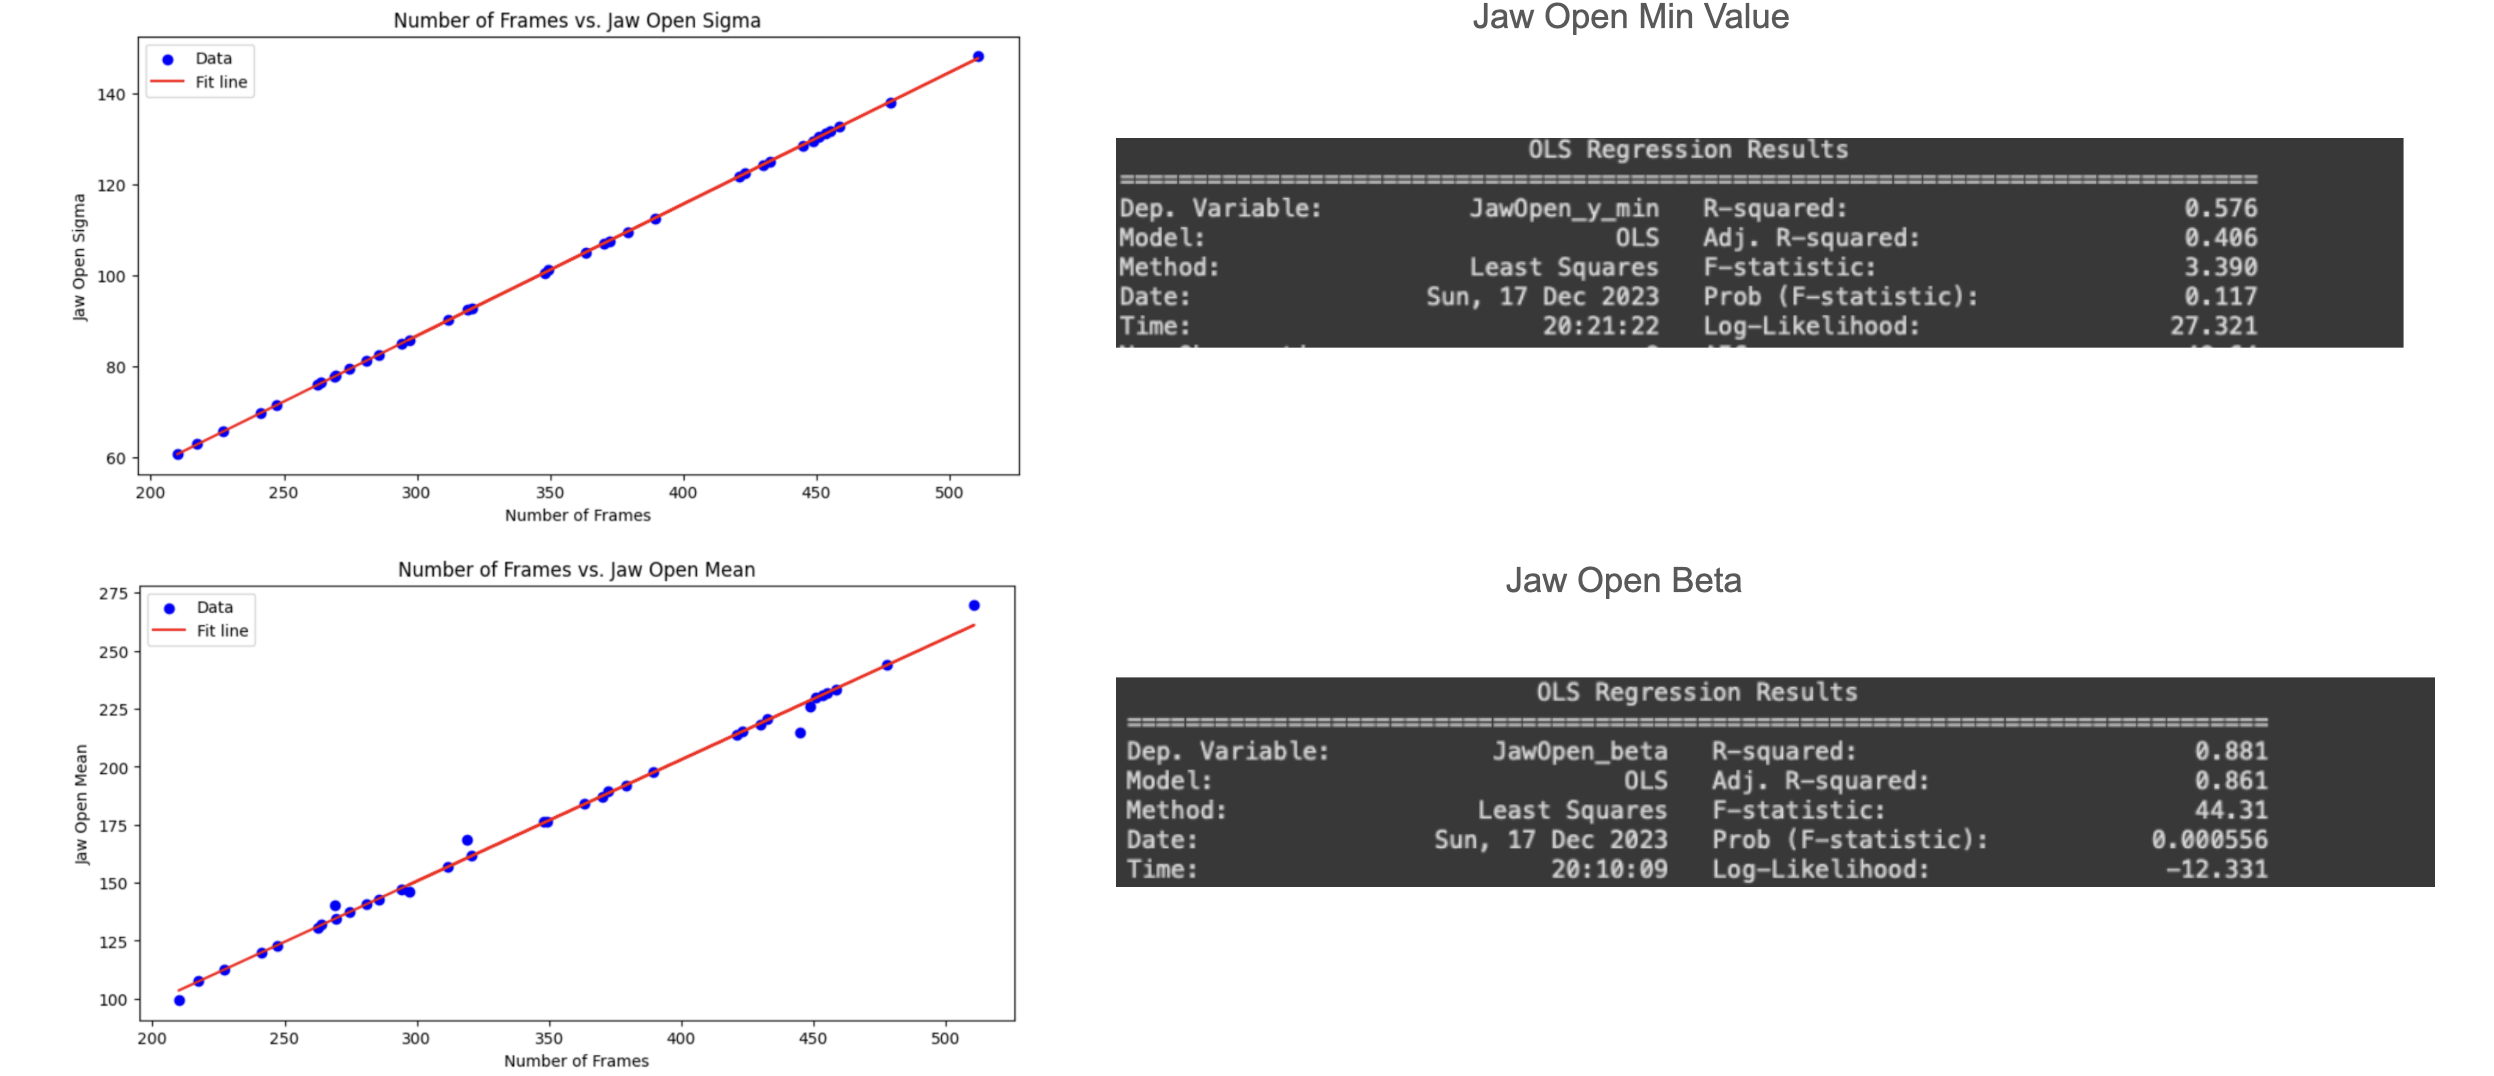

Given jaw open curve, how can we find other three phases blendshapes' curves? We calculated correlation between blendshapes to see which blendshapes are strongly correlated to JawOpen blendshape.

In [ ]:
csv_files = glob.glob('*.csv')
dataframes = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df = combined_df.drop(['Timecode', 'BlendshapeCount'], axis=1)
correlation_df = combined_df.corr()
# correlation_df.to_csv("correlation.csv")

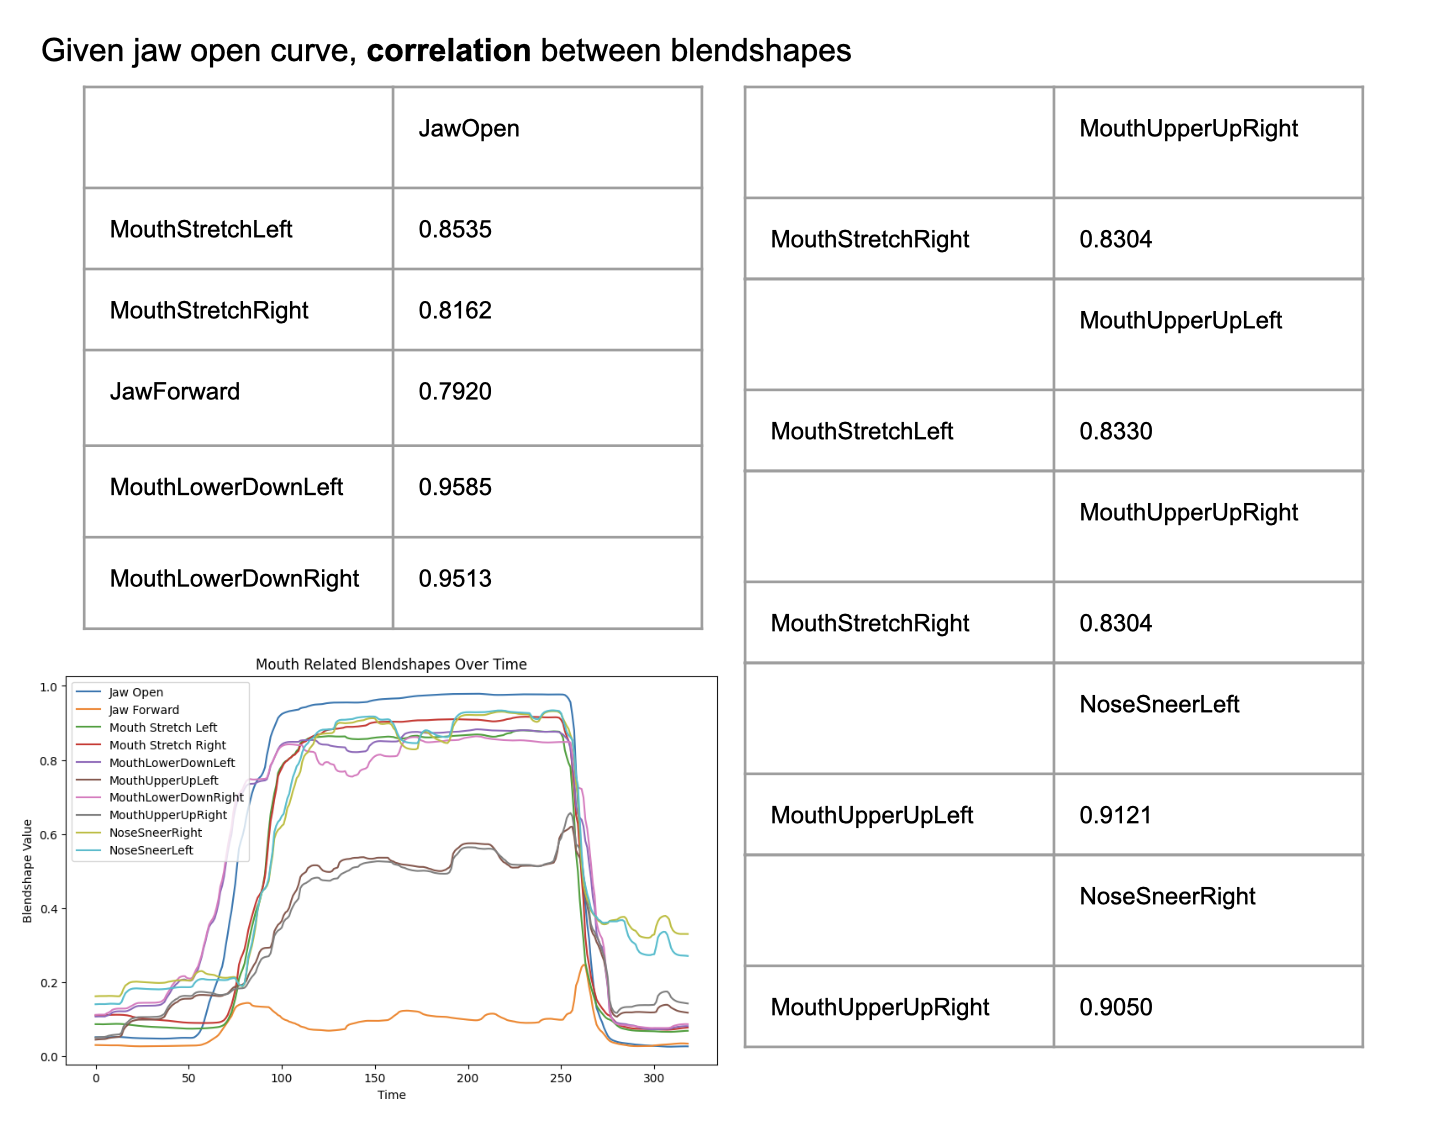

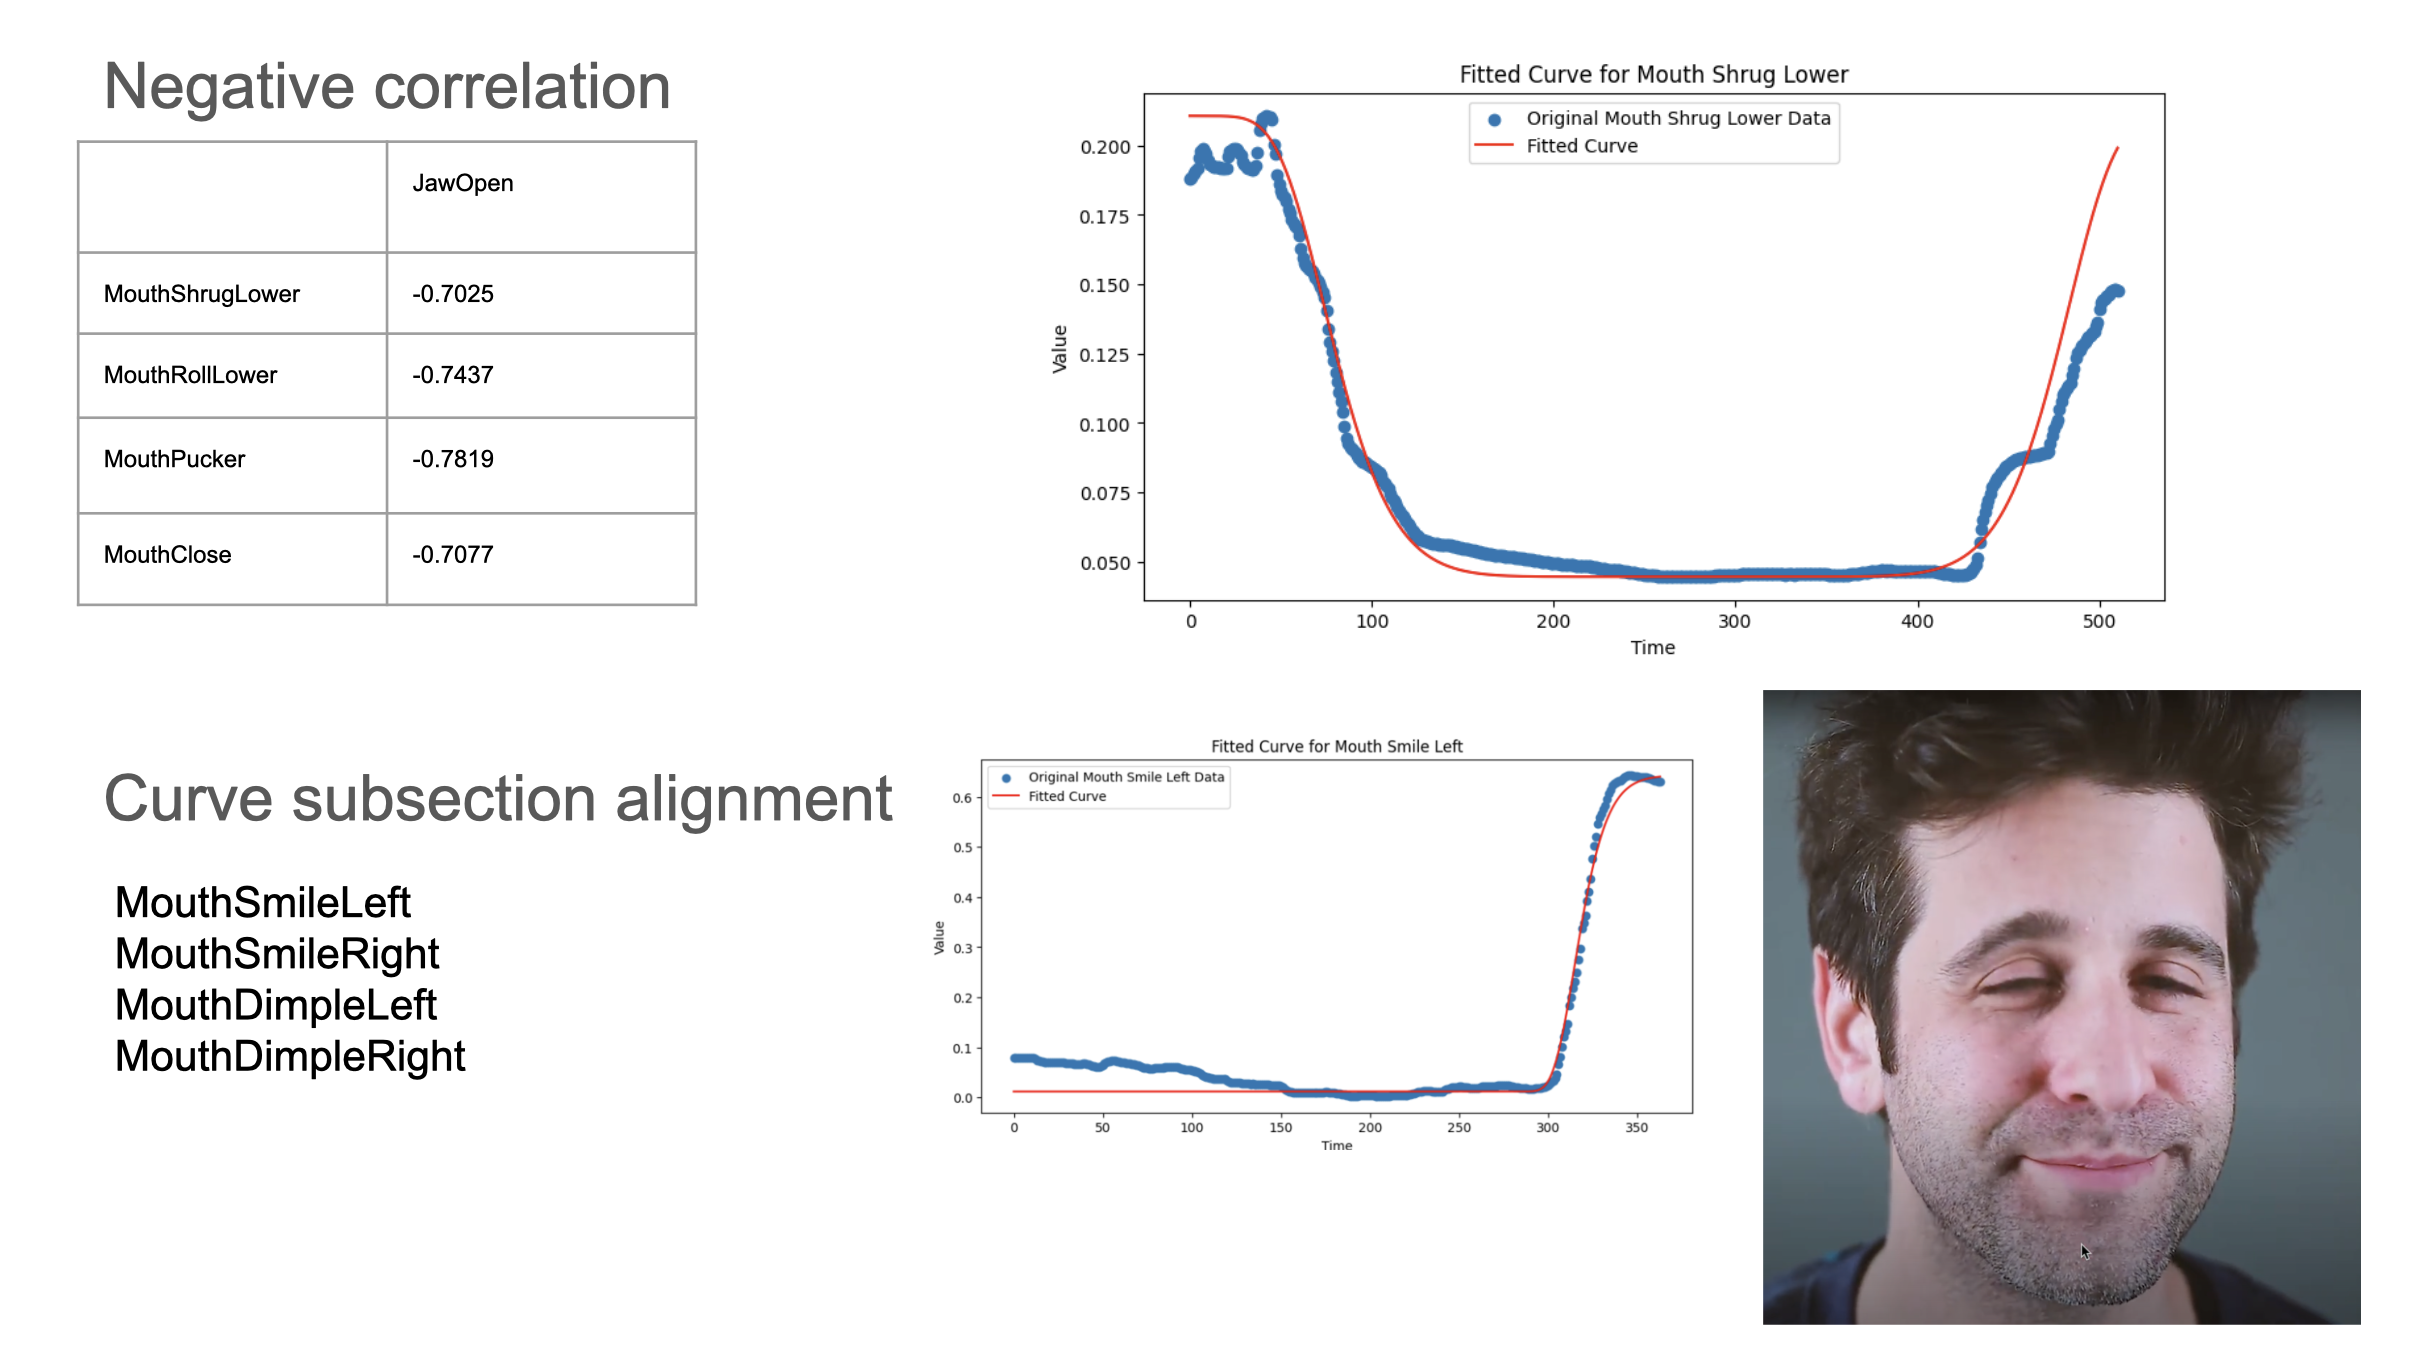

For the blendshapes that are strongly correlated to JawOpen, we have found there is linear relationship between jaw open related parameters and other blendshape's parameters.

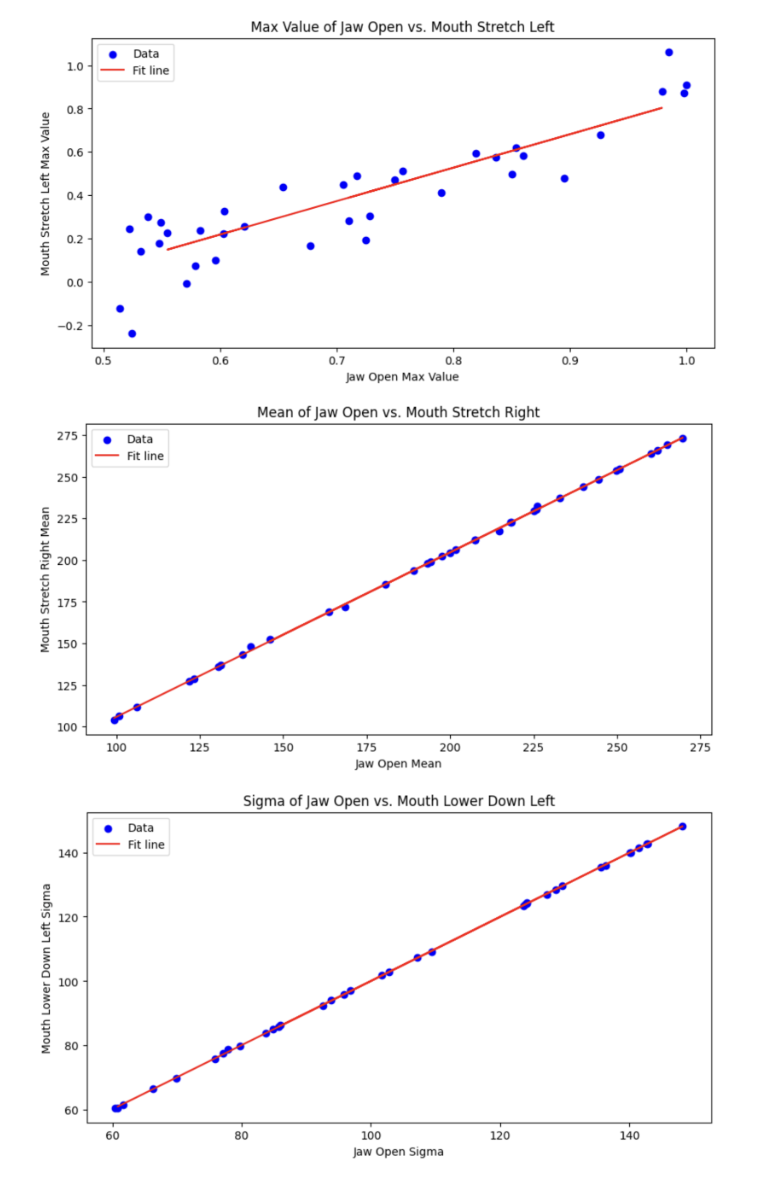

So here we will find linear models between

*   max value, number of frames and jaw open related parameters
*   jaw open related parameters and other blendshape's parameters


In [ ]:
models = {}

In [ ]:
import statsmodels.api as sm

# fit linear models between jaw open related parameters and other blendshape's parameters
blendshapes = blendshapes + ["NoseSneerLeft", "NoseSneerRight"]
for blendshape in blendshapes:
  for para in ["beta", "sigma", "y_min", "mean", "max_value"]:
    if blendshape == "NoseSneerLeft" or blendshape == "NoseSneerRight":
      X = nose_summary[[f"JawOpen_{para}"]]
      y_alpha = nose_summary[f"{blendshape}_{para}"]
    else:
      X = summary_df[[f"JawOpen_{para}"]]
      y_alpha = summary_df[f"{blendshape}_{para}"]
    X = sm.add_constant(X)
    model = sm.OLS(y_alpha, X).fit()
    models[f"{blendshape}_{para}"] = model

# fit linear models between max value and jaw open's beta
X = summary_df[["JawOpen_max_value"]]
y_alpha = summary_df['JawOpen_beta']
X = sm.add_constant(X)
model_jaw_open_beta = sm.OLS(y_alpha, X).fit()
models[f"JawOpen_beta"] = model_jaw_open_beta

# fit linear models between number of frames and jaw open's sigma
X = summary_df[['num_frames']]
y_alpha = summary_df['JawOpen_sigma']
X = sm.add_constant(X)
model_jaw_open_sigma = sm.OLS(y_alpha, X).fit()
models[f"JawOpen_sigma"] = model_jaw_open_sigma

# fit linear models between number of frames and jaw open's mean
X = summary_df[['num_frames']]
y_alpha = summary_df['JawOpen_mean']
X = sm.add_constant(X)
model_jaw_open_mean= sm.OLS(y_alpha, X).fit()
models[f"JawOpen_mean"] = model_jaw_open_mean

# fit linear models between max value, number of frames and jaw open's min
X = summary_df[['num_frames', 'JawOpen_max_value']]
y_alpha = summary_df['JawOpen_y_min']
X = sm.add_constant(X)
model_jaw_open_y_min = sm.OLS(y_alpha, X).fit()
models[f"JawOpen_y_min"] = model_jaw_open_y_min

# Mouth/Jaw/Cheek/Nose/Head-related blendshapes generator

Now we have the linear models, we can use max value and number of frames (calculated from duration) provided by the user to find jaw open curve, then use jaw open curve to find other blendshapes' curves

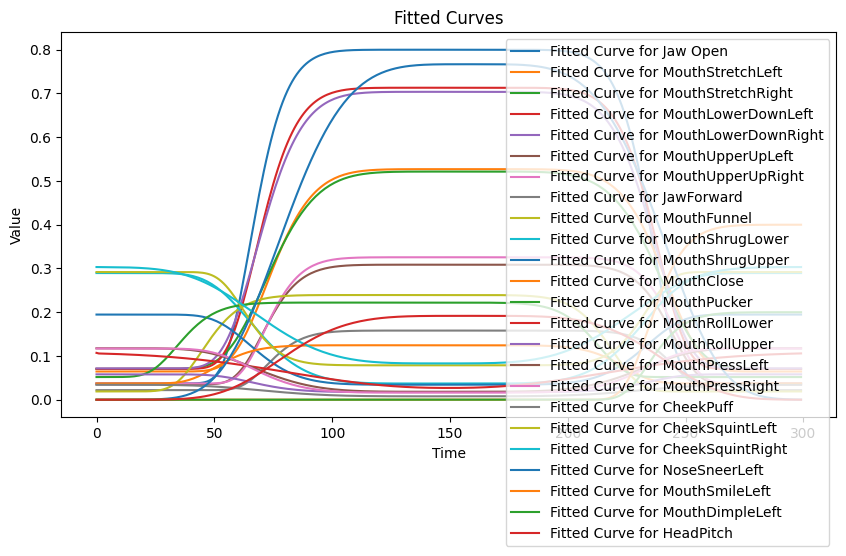

In [ ]:
# provided by user
jaw_open_max_value = 0.8
duration = 300

generate_blendshapes = ["MouthStretchLeft", "MouthStretchRight", "MouthLowerDownLeft",
               "MouthLowerDownRight", "MouthUpperUpLeft", "MouthUpperUpRight",
               "JawForward", "MouthFunnel", 'MouthShrugLower', 'MouthShrugUpper',
               "MouthClose", "MouthPucker", "MouthRollLower", "MouthRollUpper",
               "MouthPressLeft", "MouthPressRight", "CheekPuff", "CheekSquintLeft",
               "CheekSquintRight", "NoseSneerLeft", "NoseSneerRight", "MouthSmileLeft",
                        "MouthSmileRight", "MouthDimpleLeft", "MouthDimpleRight", "HeadPitch"]

curves = {}
time_data = pd.RangeIndex(start=0, stop=duration, step=1)
# Use max value and number of frames provided by the user to find jaw open curve
jaw_open_beta = model_jaw_open_beta.predict([1, jaw_open_max_value])[0]
jaw_open_mean = model_jaw_open_mean.predict([1, duration])[0]
jaw_open_sigma = model_jaw_open_sigma.predict([1, duration])[0]
jaw_open_y_min = model_jaw_open_y_min.predict([1, duration, jaw_open_max_value])[0]

plt.figure(figsize=(10, 5))
jaw_open_curve = skewed_gennorm_pdf(time_data, jaw_open_beta, jaw_open_max_value, jaw_open_sigma, jaw_open_y_min, jaw_open_mean)
curves["JawOpen"] = jaw_open_curve
plt.plot(time_data, jaw_open_curve, label='Fitted Curve for Jaw Open')

# Use jaw open curve to find other blendshapes' curves
for i, blendshape in enumerate(generate_blendshapes):
    max_value = models[f"{blendshape}_max_value"].predict([1, jaw_open_max_value])[0]
    beta = models[f"{blendshape}_beta"].predict([1, jaw_open_beta])[0]
    mean = models[f"{blendshape}_mean"].predict([1, jaw_open_mean])[0]
    sigma = models[f"{blendshape}_sigma"].predict([1, jaw_open_sigma])[0]
    y_min = max(models[f"{blendshape}_y_min"].predict([1, jaw_open_y_min])[0], 0)
    # variant of skewed generalized normalized distribution (1-skewed generalized normalized distribution)
    if blendshape == "MouthShrugLower" or blendshape == "MouthShrugUpper" or \
    blendshape == "MouthRollLower" or blendshape == "MouthRollUpper" or \
    blendshape == "MouthPressLeft" or blendshape == "MouthPressRight" or \
    blendshape == "CheekPuff" or blendshape == "CheekSquintLeft" or \
    blendshape == "CheekSquintRight":
      fitted_curve = 1-skewed_gennorm_pdf(time_data, beta, max_value, sigma, y_min, mean)
    else:
      fitted_curve = skewed_gennorm_pdf(time_data, beta, max_value, sigma, y_min, mean)
    # avoid having value not in range [0, 1]
    if fitted_curve.min() < 0:
      fitted_curve = 0
    curves[blendshape] = fitted_curve
    plt.plot(time_data, curves[blendshape], label=f"Fitted Curve for {blendshape}")

plt.title('Fitted Curves')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Store generated curves to a new dataframe

In [ ]:
# get all blendshape column names
df = pd.read_csv('MySlate_2_iPhone.csv')
all_columns = df.columns
new = pd.DataFrame(np.zeros((duration, len(all_columns))), columns=all_columns)
new['Timecode'] = [i/60 for i in range(duration)]
blendshapes = ["JawOpen"] + generate_blendshapes
for blendshape in blendshapes:
  new[blendshape] = curves[blendshape]

# Mouth Crookness

Mouth Crookness is controlled by JawRight blendshape, find curve for JawRight based on JawOpen curve.

Based on the plots below and OLS Regression results, there is a linear relationship between JawOpen's max value and the value of JawOpen at the exact moment when JawRight reaches its maximum.

Given that the user provides the maximum value for JawOpen, we can find the value of JawOpen at the exact moment when JawRight reaches its maximum. This allows us to identify the exact time JawRight reaches its maximum, which will also be the mean of JawRight.

The max value for JawRight will be provided by the user (Mouth Crooked), and based on our analysis, min value will always be 0, JawRight's sigma and beta will be the same as JawOpen's sigma and beta.

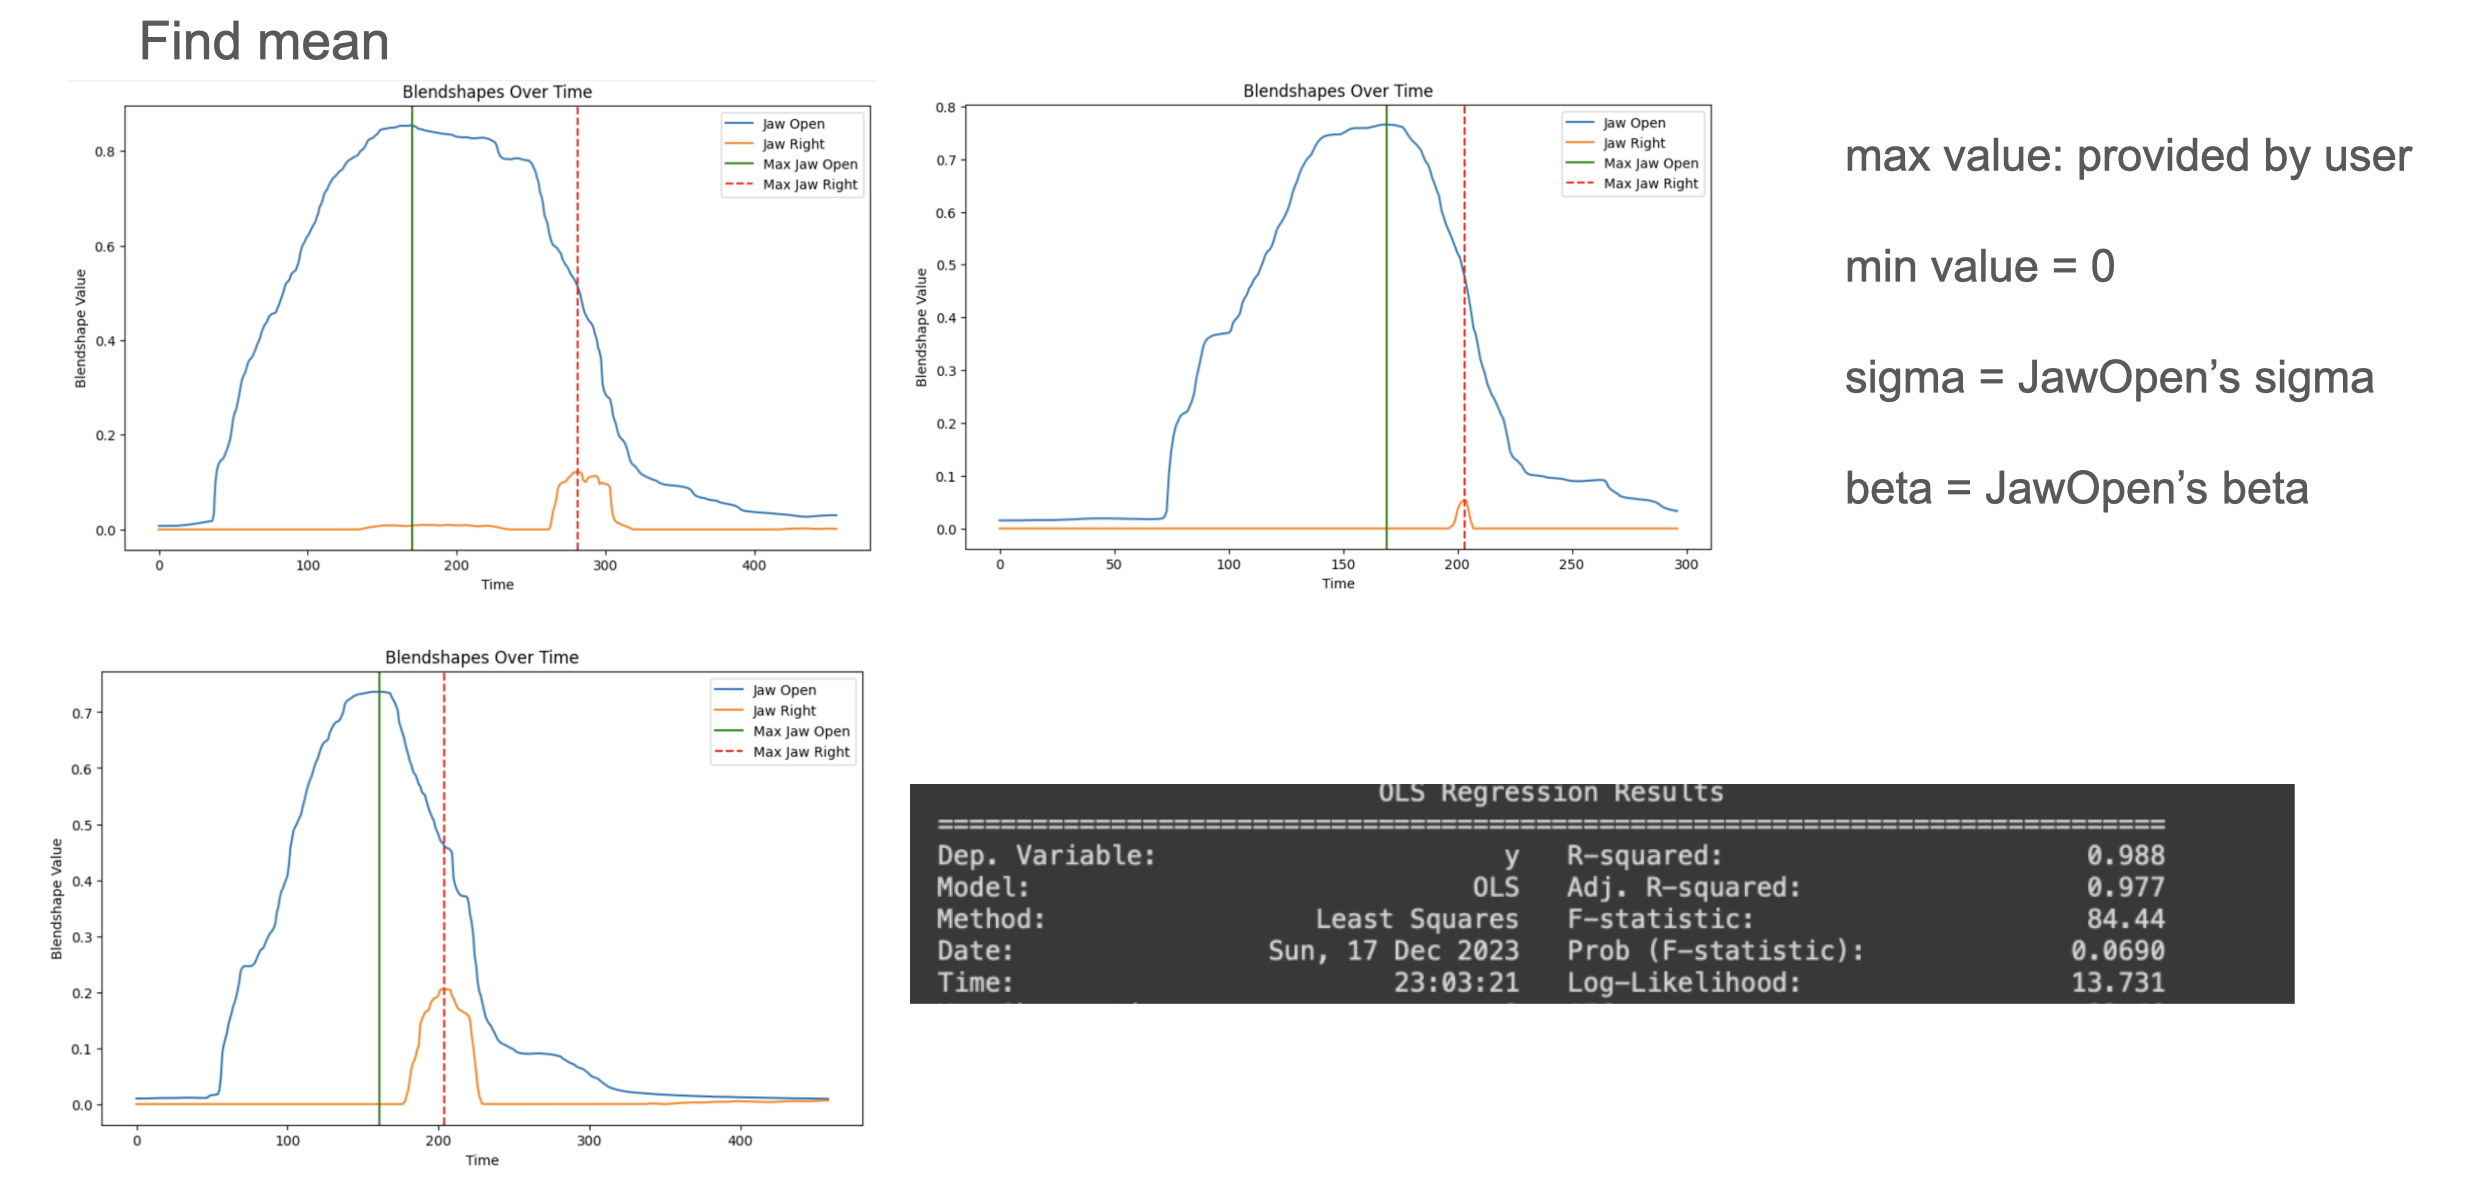

In [ ]:
# Finding the index of the maximum value in the 'JawRight' column
max_jaw_open = []
corresponding_jaw_open = []
# yawning data with jaw right
csv_files = ["MySlate_48_iPhone.csv", "MySlate_49_iPhone.csv", "MySlate_51_iPhone.csv"]
for csv_file in csv_files:
  df = pd.read_csv(csv_file)
  max_jaw_right_index = df['JawRight'].idxmax()

  # Retrieving the corresponding 'JawOpen' value at that index
  max_jaw_open_value = df['JawOpen'].max()
  corresponding_jaw_open_value = df.loc[max_jaw_right_index, 'JawOpen'] if 'JawOpen' in df.columns else "JawOpen column not found"

  max_jaw_right_index, max_jaw_open_value, corresponding_jaw_open_value
  max_jaw_open.append(max_jaw_open_value)
  corresponding_jaw_open.append(corresponding_jaw_open_value)

In [ ]:
# find the corresponding JawOpen value of max peak for JawRight
import statsmodels.api as sm
max_jaw_open = sm.add_constant(max_jaw_open)
model_jaw_right = sm.OLS(corresponding_jaw_open, max_jaw_open).fit()
target_jaw_open = model_jaw_right.predict([1, jaw_open_max_value])[0]

In [ ]:
# find timecode for target_jaw_open, which will also be the mean for JawRight
tolerance = 5e-2
matching_rows = new[(new['JawOpen'] >= target_jaw_open - tolerance) & (new['JawOpen'] <= target_jaw_open + tolerance) & (new.index > jaw_open_mean)]
latest_timecode = matching_rows['Timecode'].max()
jaw_right_mean = new[new['Timecode'] == latest_timecode].index[0]

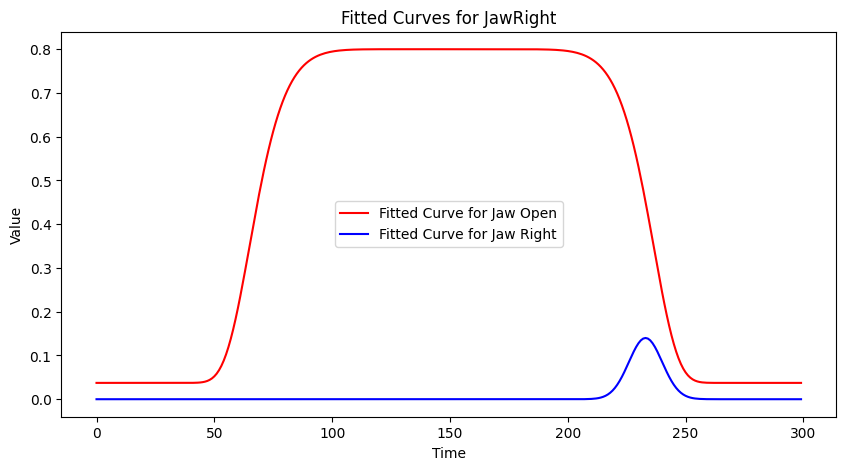

In [ ]:
# provided by user
mouth_crookness = 0.5

# damping factor for JawRight max value
jaw_right_max_ratio = 0.35
plt.figure(figsize=(10, 5))
time_data = pd.RangeIndex(start=0, stop=duration, step=1)
curves["JawOpen"] = skewed_gennorm_pdf(time_data, jaw_open_beta, jaw_open_max_value, jaw_open_sigma, jaw_open_y_min, jaw_open_mean)
plt.plot(time_data, skewed_gennorm_pdf(time_data, jaw_open_beta, jaw_open_max_value, jaw_open_sigma, jaw_open_y_min, jaw_open_mean), color='red', label='Fitted Curve for Jaw Open')
curves["JawRight"] = skewed_gennorm_pdf(time_data, jaw_open_beta, jaw_right_max_ratio*jaw_open_max_value*mouth_crookness, jaw_open_sigma, 0, jaw_right_mean)
plt.plot(time_data, skewed_gennorm_pdf(time_data, jaw_open_beta, jaw_right_max_ratio*jaw_open_max_value*mouth_crookness, jaw_open_sigma, 0, jaw_right_mean), color='blue', label='Fitted Curve for Jaw Right')

plt.title('Fitted Curves for JawRight')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
new["JawRight"] = curves["JawRight"]
new.to_csv("generated_yawning.csv", index=False)